# Bad Bunny songs analyzed by popularity, release year, and musical genre (reggaeton or not)

**Author**: Santiago Velasco García  
**Date**: May 2025

This project explores the popularity of Bad Bunny's songs using data from the Spotify API. The main objective is to test the hypothesis that Bad Bunny's reggaeton tracks are generally more popular than his songs in other genres. Through data collection, cleaning, and analysis, we aim to uncover patterns and insights about genre influence on song popularity.

To carry out the analysis, we used key data science libraries such as **NumPy**, **Pandas**, **Matplotlib**, **Seaborn**, and **SciPy Stats**. These tools allowed us to efficiently manipulate the data, perform statistical tests, and generate insightful visualizations.

We applied **multiple analytical approaches**:
- Individual-level analysis across all tracks  
- Grouped analysis at the **album level**  
- Use of **statistical tests** like correlation and t-tests to evaluate significance  
- **Graphical exploration** to identify trends and compare distributions visually

This multi-faceted strategy provided a more comprehensive understanding of how genre—specifically reggaeton—influences the popularity of Bad Bunny’s music over time.


### Installing Dependencies

We start by installing the `spotipy` library, which provides easy access to the Spotify Web API. This package allows us to authenticate with Spotify and retrieve track data, including audio features and popularity metrics.


In [99]:
!pip install spotipy

### Spotify API Authentication

To access data from Spotify, we authenticate using the **Client Credentials Flow**, which is suitable for read-only access (like fetching public track and artist data).

We use the `spotipy` library to handle authentication and interaction with the Spotify Web API. After providing our `CLIENT_ID` and `CLIENT_SECRET`, we create an authenticated `Spotify` object (`sp`) that allows us to make requests.

As a first test, we search for the artist "Bad Bunny" and print the name of the first result to confirm that the connection is working correctly.

In [100]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# Spotify app credentials
CLIENT_ID = '04afb9a4dfc34a2ba6ab9fefc30358b5'
CLIENT_SECRET = '44ef46e579df499c8a155933264a04fb'

# Authentication using Client Credentials Flow
auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

# Search for Bad Bunny and print if found
result = sp.search(q='Bad Bunny', type='artist', limit=1)
print(result['artists']['items'][0]['name'])

Bad Bunny


### Collecting Bad Bunny's Discography

In this section, we retrieve Bad Bunny's complete discography—both albums and singles—using the Spotify API.

We:
- Define a function to retrieve all albums or singles, handling pagination.
- Fetch both albums and singles separately and merge them.
- Extract every track from these releases, storing key metadata like track name, ID, release date, duration, and album type.
- Request the popularity score for each track using the Spotify API (in batches of 50, due to API limits).
- Create a `pandas` DataFrame (`df_tracks`) to organize and analyze the data, adding duration in minutes and popularity as key metrics.


In [101]:
import pandas as pd
import numpy as np
from time import sleep

# Obtener el ID del artista
bad_bunny_id = result['artists']['items'][0]['id']

# Function to get all albums or singles from the artist (handles pagination)
def get_all_albums(artist_id, album_type='album'):
    albums = []
    results = sp.artist_albums(artist_id, album_type=album_type, limit=50)
    albums += results['items']
    while results['next']:
        results = sp.next(results)
        albums += results['items']
    return albums

# Retrieve albums and singles separately
albums = get_all_albums(bad_bunny_id, album_type='album')
singles = get_all_albums(bad_bunny_id, album_type='single')
all_releases = albums + singles

# Create sets of album and single IDs for reference
album_ids_set = {album['id'] for album in albums}
single_ids_set = {single['id'] for single in singles}

# Remove duplicate album IDs
album_ids = list({album['id'] for album in all_releases})

# Extract track data from each album/single
tracks_data = []

for album_id in album_ids:
    album = sp.album(album_id)
    release_date = album['release_date']
    album_name = album['name']

    # Rename album to "Single" if it's a single release
    if album_id in single_ids_set:
        album_name = 'Single'

    tracks = album['tracks']['items']
    
    for track in tracks:
        tracks_data.append({
            'track_name': track['name'],
            'track_id': track['id'],
            'album': album_name,
            'release_date': release_date,
            'duration_ms': track['duration_ms']
        })

# Convert list of track dictionaries into a pandas DataFrame
df_tracks = pd.DataFrame(tracks_data)

# Retrieve popularity scores in batches of 50 (Spotify API limit)
popularities = []
track_ids = df_tracks['track_id'].tolist()

for i in range(0, len(track_ids), 50):
    batch = track_ids[i:i+50]
    try:
        track_infos = sp.tracks(batch)['tracks']
        popularities += [track['popularity'] for track in track_infos]
    except:
        popularities += [None] * len(batch)
        sleep(1)

# Add popularity and duration in minutes to the DataFrame
df_tracks['popularity'] = popularities
df_tracks['duration_min'] = df_tracks['duration_ms'] / 60000


df_tracks


,track_name,track_id,album,release_date,duration_ms,popularity,duration_min
0,Tranquilo,4PE7pAJ3DDmJdxWzpsXrlS,Single,2017-03-24,215593,50,3.593217
1,K-POP,5L3ecxQnQ9qTBmnLQiwf0C,Single,2023-07-21,185220,72,3.087000
2,NADIE SABE,23d8v6tU6lR77pFKsApMtF,nadie sabe lo que va a pasar mañana,2023-10-13,379058,72,6.317633
3,MONACO,4MjDJD8cW7iVeWInc2Bdyj,nadie sabe lo que va a pasar mañana,2023-10-13,267194,81,4.453233
4,FINA,3nNmRE0DxHC6ZaKkrpUumS,nadie sabe lo que va a pasar mañana,2023-10-13,216327,76,3.605450
...,...,...,...,...,...,...,...
217,QUE PRETENDES,25ZAibhr3bdlMCLmubZDVt,OASIS,2019-06-28,222346,82,3.705767
218,LA CANCIÓN,0fea68AdmYNygeTGI4RC18,OASIS,2019-06-28,242573,88,4.042883
219,UN PESO,7hynhxDoDpgMIV12JuVtNa,OASIS,2019-06-28,277106,80,4.618433
220,ODIO,7alOsNr36sJ8CyOEP4aILq,OASIS,2019-06-28,270400,62,4.506667


In [102]:
# Convert release_date column to datetime format for easier analysis
df_tracks['release_date'] = pd.to_datetime(df_tracks['release_date'])
df_tracks['release_date']

0     2017-03-24
1     2023-07-21
2     2023-10-13
3     2023-10-13
4     2023-10-13
         ...    
217   2019-06-28
218   2019-06-28
219   2019-06-28
220   2019-06-28
221   2019-06-28
Name: release_date, Length: 222, dtype: datetime64[ns]

In [103]:
df_tracks[df_tracks['track_name'].str.contains('where she goes', case=False, na=False)]

,track_name,track_id,album,release_date,duration_ms,popularity,duration_min
18,WHERE SHE GOES,2sTDlCxmuZCTDKKk9f1qus,nadie sabe lo que va a pasar mañana,2023-10-13,231704,72,3.861733
158,WHERE SHE GOES,7ro0hRteUMfnOioTFI5TG1,Single,2023-05-18,231704,78,3.861733


⚠️ Example check for duplicate entries: some tracks may appear more than once if released as a single and later as part of an album.

In [104]:
df_tracks[df_tracks['album']=='Single']

,track_name,track_id,album,release_date,duration_ms,popularity,duration_min
0,Tranquilo,4PE7pAJ3DDmJdxWzpsXrlS,Single,2017-03-24,215593,50,3.593217
1,K-POP,5L3ecxQnQ9qTBmnLQiwf0C,Single,2023-07-21,185220,72,3.087000
47,Tu No Metes Cabra,43SMQMC2X2fAOuTPRnSGrG,Single,2017-07-06,170762,69,2.846033
48,Satisfacción,21WvAGxPUNJARcZoSqswd7,Single,2018-08-03,256493,51,4.274883
49,Vete,5DxXgozhkPLgrbKFY91w0c,Single,2019-11-21,192024,72,3.200400
...,...,...,...,...,...,...,...
193,Amorfoda,68QcquxCS39cQGTsRrJWIR,Single,2018-02-15,153887,76,2.564783
194,Krippy Kush (feat. Travis Scott & Rvssian) - T...,6HdVpbKJtp4EDpfli4fcOm,Single,2017-12-25,236953,46,3.949217
195,DÁKITI,47EiUVwUp4C9fGccaPuUCS,Single,2020-10-30,205090,81,3.418167
212,Loca - Remix,2ECIwi1a7mfokdDkkJ08Ne,Single,2018-03-16,346460,70,5.774333


### Exporting Track Names for Manual Genre Labeling

To manually label each track as reggaeton or not, we export a list of all unique track names to an Excel file. This file will be edited outside the notebook to add a new column indicating whether a track belongs to the reggaeton genre (1 for reggaeton, 0 for other genres).

⚠️ Important: To avoid overwriting the labeled file after filling it, we save it under a different name (`tracks_bb_filled.xlsx`) before running this cell again.


In [105]:
df_tracks[['track_name']].drop_duplicates().to_excel('canciones_bb.xlsx', index=False)


In [106]:
df_labels = pd.read_excel('canciones_bb_filled.xlsx')
df_tracks = df_tracks.merge(df_labels, on='track_name', how='left')

# Remove tracks that were not labeled (e.g., songs released after the date of this analysis: April 30, 2025)
df_tracks = df_tracks.dropna(subset=['is_reggaeton'])


df_tracks.head(20)

,track_name,track_id,album,release_date,duration_ms,popularity,duration_min,is_reggaeton
0,Tranquilo,4PE7pAJ3DDmJdxWzpsXrlS,Single,2017-03-24,215593,50,3.593217,0
1,K-POP,5L3ecxQnQ9qTBmnLQiwf0C,Single,2023-07-21,185220,72,3.087000,0
2,NADIE SABE,23d8v6tU6lR77pFKsApMtF,nadie sabe lo que va a pasar mañana,2023-10-13,379058,72,6.317633,0
3,MONACO,4MjDJD8cW7iVeWInc2Bdyj,nadie sabe lo que va a pasar mañana,2023-10-13,267194,81,4.453233,0
4,FINA,3nNmRE0DxHC6ZaKkrpUumS,nadie sabe lo que va a pasar mañana,2023-10-13,216327,76,3.605450,0
5,HIBIKI,4qSEvFGCpde73gqIuq3sho,nadie sabe lo que va a pasar mañana,2023-10-13,208000,73,3.466667,0
6,MR. OCTOBER,1ODFVLQszq0hCOdZtqV5wq,nadie sabe lo que va a pasar mañana,2023-10-13,189258,71,3.154300,0
7,CYBERTRUCK,4Jc7252S1P99DjQ1lNGEOc,nadie sabe lo que va a pasar mañana,2023-10-13,191959,72,3.199317,0
8,VOU 787,0rDQZJtSGgsB2rdkObpdFa,nadie sabe lo que va a pasar mañana,2023-10-13,123643,67,2.060717,0
9,SEDA,1YnChEM51BVZ5dRhbVFEMl,nadie sabe lo que va a pasar mañana,2023-10-13,190476,72,3.174600,0


After labeling the tracks manually in the Excel file `tracks_bb_filled.xlsx`, we load it back into the notebook and merge it with the original `df_tracks` DataFrame. This adds a new column called `is_reggaeton`, which allows us to differentiate and analyze tracks by genre.

### Correlation Between Popularity and Reggaeton Label

Even though the column `is_reggaeton` is conceptually categorical (1 for reggaeton, 0 for not reggaeton), it's still possible to compute a Pearson correlation between it and a numerical column like `popularity`.

This works because the values 0 and 1 can be treated as numeric. In fact, when a binary categorical variable is encoded this way, the correlation tells you whether there's a linear relationship between belonging to the category (in this case, being a reggaeton track) and the numerical variable (popularity).

So, a positive correlation would suggest that reggaeton tracks tend to be more popular, while a negative correlation would suggest the opposite. A correlation close to 0 would mean there's no clear linear relationship.

In [107]:
correlation = df_tracks['popularity'].corr(df_tracks['is_reggaeton'])
print(correlation)

0.29283698407550374


The Pearson correlation between `popularity` and `is_reggaeton` is approximately **0.29**.

This is a **positive but moderate** correlation, meaning that — in general — Bad Bunny's reggaeton songs tend to be more popular than his non-reggaeton songs. However, the correlation is not very strong, so this trend is not absolute. There are likely popular non-reggaeton songs and less popular reggaeton songs as well.

Also, keep in mind that correlation does **not imply causation**. This result doesn’t mean that a song is popular *because* it's reggaeton — only that, in this dataset, popularity and the reggaeton label move together to some extent.

We'll explore this relationship further using other statistical approaches, such as grouping songs by album and comparing means using t-tests. These additional analyses will help us determine whether the differences in popularity are statistically significant and whether they vary across contexts.

In [108]:
df_tracks['is_reggaeton'] = df_tracks['is_reggaeton'].replace({
    1: 'is reggaeton',
    0: 'is not reggaeton'
})
df_tracks.groupby('is_reggaeton').agg(
    avg_popularity=('popularity', np.mean),
    track_count=('track_name', 'count'))

,avg_popularity,track_count
is_reggaeton,,
is not reggaeton,66.784173,139
is reggaeton,74.156627,83


We can see that:
- On average, reggaeton tracks by Bad Bunny are **more popular** than his non-reggaeton tracks.
- Despite being **fewer in number** (83 vs. 139), reggaeton songs have a noticeably higher average popularity (74.16 vs. 66.78).
- This supports the initial correlation we observed, but here we can also see the magnitude of the difference in popularity between the two groups.

### T-Test: Comparing Popularity Between Reggaeton and Non-Reggaeton Songs

To determine whether there is a statistically significant difference in the average popularity between reggaeton and non-reggaeton songs, we apply an **independent two-sample t-test**. This test compares the means of two independent groups and tells us whether any observed difference is likely due to random chance or reflects a real effect. 

In this case, we test the null hypothesis that both groups (reggaeton and non-reggaeton tracks) have the same mean popularity.


In [109]:
from scipy.stats import ttest_ind

# Filtering
reggaeton_pop = df_tracks[df_tracks['is_reggaeton'] == 'is reggaeton']['popularity']
no_reggaeton_pop = df_tracks[df_tracks['is_reggaeton'] == 'is not reggaeton']['popularity']

# Apply t-test
t_stat, p_value = ttest_ind(reggaeton_pop, no_reggaeton_pop, equal_var=False)

print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 4.705603949369917
p-value: 4.8383028134525255e-06


To determine whether the observed difference in average popularity between reggaeton and non-reggaeton tracks is statistically significant, we applied an independent samples t-test (assuming unequal variances).

**Test results:**

- **t-statistic:** 4.71  
- **p-value:** 4.84e-06

The p-value is far below the common significance level of 0.05, which indicates that the difference in average popularity between reggaeton and non-reggaeton tracks is **statistically significant**.

In other words, it's extremely unlikely that this difference occurred by chance. We can reasonably conclude that, in this dataset, **Bad Bunny's reggaeton songs are significantly more popular than his non-reggaeton songs**.

In [110]:
df_tracks['release_year'] = df_tracks['release_date'].dt.year

df_tracks['pred_genre'] = df_tracks.groupby('album')['is_reggaeton'].transform(
    lambda x: 'reggaeton' if (x == 'is reggaeton').sum() > (x == 'is not reggaeton').sum() else 'not reggaeton')

df_tracks['regtracks_count'] = df_tracks.groupby('album')['is_reggaeton'].transform(
    lambda x: (x == 'is reggaeton').sum())

df_tracks['nregtracks_count'] = df_tracks.groupby('album')['is_reggaeton'].transform(
    lambda x: (x == 'is not reggaeton').sum())


df_albums = df_tracks.groupby('album').agg(
    avg_popularity=('popularity', np.mean),
    track_count=('track_name', 'count'),
    release_year=('release_year','first'),
    pred_genre=('pred_genre','first'),
    regtracks_count=('regtracks_count','first'),
    nregtracks_count=('nregtracks_count','first')
    )
df_albums['reggaeton_pct'] = (df_albums['regtracks_count'] / df_albums['track_count']) * 100

df_albums_ns = df_albums.drop(labels='Single', axis=0)

df_albums_ns.head(10)

,avg_popularity,track_count,release_year,pred_genre,regtracks_count,nregtracks_count,reggaeton_pct
album,,,,,,,
DeBÍ TiRAR MáS FOToS,88.235294,17,2025,not reggaeton,7,10,41.176471
EL ÚLTIMO TOUR DEL MUNDO,69.750000,16,2020,not reggaeton,3,13,18.750000
LAS QUE NO IBAN A SALIR,63.200000,10,2020,reggaeton,6,4,60.000000
OASIS,70.875000,8,2019,reggaeton,6,2,75.000000
Un Verano Sin Ti,79.695652,23,2022,reggaeton,16,7,69.565217
X 100PRE,68.933333,15,2018,not reggaeton,4,11,26.666667
YHLQMDLG,72.750000,20,2020,reggaeton,12,8,60.000000
nadie sabe lo que va a pasar mañana,69.681818,22,2023,not reggaeton,2,20,9.090909


In [111]:
corr1 = df_albums_ns['avg_popularity'].corr(df_albums_ns['regtracks_count'])
print(corr1)
corr2 = df_albums_ns['avg_popularity'].corr(df_albums_ns['nregtracks_count'])
print(corr2)
corr3 = df_albums_ns['avg_popularity'].corr(df_albums_ns['reggaeton_pct'])
print(corr3)

0.4399184902457555
0.028665965328842805
0.1280092920751711


### Correlation Analysis Between Album Popularity and Reggaeton Content

We compute the Pearson correlation coefficients between the average popularity of albums and different measures of reggaeton content:

- **corr1:** A moderate positive correlation (~0.44) between the number of reggaeton tracks in an album and its average popularity. This suggests that albums with more reggaeton tracks tend to be more popular.

- **corr2:** A negligible correlation (~0.03) between the number of non-reggaeton tracks and popularity. This implies almost no relationship.

- **corr3:** A weak positive correlation (~0.13) between the percentage of reggaeton tracks in the album and popularity. There is a slight trend, but it is not strong.

Overall, the number of reggaeton tracks appears more relevant to album popularity than the proportion or presence of non-reggaeton tracks.

### Why a T-Test Was Not Performed on Albums

The popularity metric in Spotify’s API is **dynamic**—it is not a fixed or historical average. Instead, it is a value between 0 and 100 that changes over time depending on recent user interactions, such as how often a track is streamed, saved, or added to playlists.

Because of this, albums released many years ago—regardless of their historical success—may show low popularity today simply because they are no longer in active rotation. Meanwhile, newer albums may appear more popular due to current streaming trends.

This introduces a **temporal bias**: comparing average popularity between genres without accounting for release date means the results may reflect differences in age rather than differences in genre. This violates the assumption of independence in a t-test, as one variable (popularity) is confounded by another (time).

Therefore, no t-test was conducted on albums, since genre and time are not independent in this context. For a fair comparison, one would need to control for release year or normalize popularity within each year.

For these reasons, no t-test was conducted on albums. A more reliable comparison would require normalizing popularity by release year or conducting the test within yearly cohorts to reduce the effect of time.

### Graphic tools

Very well, now we will try to create the appropriate graphics that will allow us to obtain relevant information for this investigation.
To begin, we will make a plot that allows us to see the number of reggaeton and non-reggaeton songs over the years.

In [112]:
count_by_genre = df_tracks.groupby(['release_year', 'is_reggaeton']).size().unstack(fill_value=0)
count_by_genre.head(10)

is_reggaeton,is not reggaeton,is reggaeton
release_year,,
2016,6,0
2017,27,3
2018,28,8
2019,6,12
2020,26,26
2021,2,5
2022,8,17
2023,23,3
2024,3,2


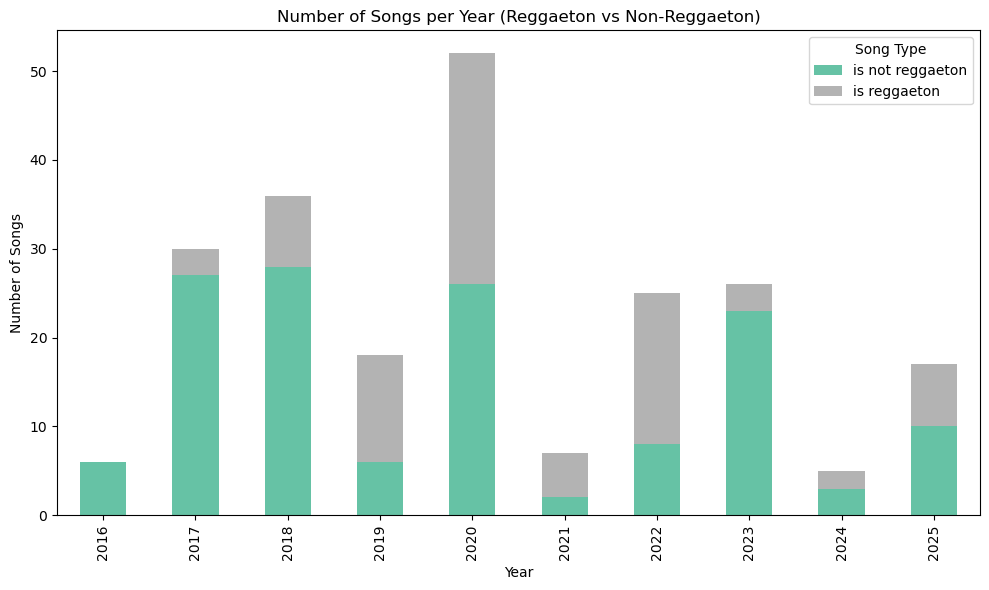

In [113]:
import matplotlib.pyplot as plt

count_by_genre.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set2')
plt.title('Number of Songs per Year (Reggaeton vs Non-Reggaeton)')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.legend(title='Song Type')
plt.tight_layout()
plt.show()

### Average Popularity by Year and Genre

We will calculate the **average popularity of songs** grouped by both their release year and whether they are reggaeton or not. The result is a table where each row corresponds to a year, and the columns show the mean popularity for reggaeton and non-reggaeton songs released that year. 

This data will be used to create a line plot comparing popularity trends over time between the two genres.


In [114]:
popularity_by_genre = df_tracks.groupby(['release_year', 'is_reggaeton'])['popularity'].mean().unstack()

popularity_by_genre

is_reggaeton,is not reggaeton,is reggaeton
release_year,,
2016,66.333333,NaN
2017,60.111111,51.666667
2018,62.678571,68.000000
2019,60.833333,68.750000
2020,66.115385,72.461538
2021,65.500000,75.400000
2022,77.000000,80.058824
2023,69.913043,74.666667
2024,67.333333,75.500000


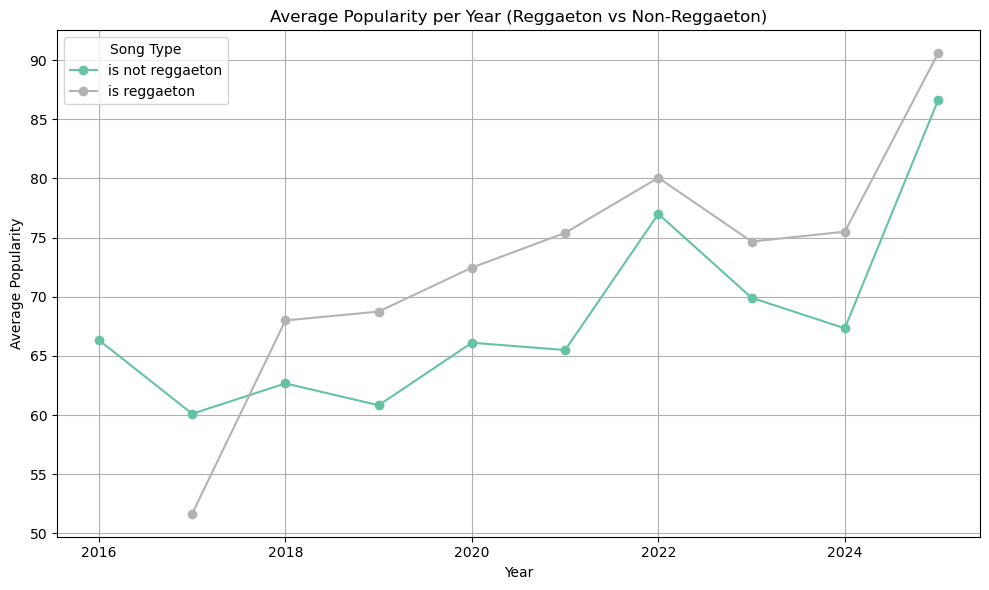

In [115]:
popularity_by_genre.plot(kind='line', figsize=(10,6), marker='o', colormap='Set2')
plt.title('Average Popularity per Year (Reggaeton vs Non-Reggaeton)')
plt.xlabel('Year')
plt.ylabel('Average Popularity')
plt.legend(title='Song Type')
plt.grid(True)
plt.tight_layout()
plt.show()

### Average Popularity per Year (Reggaeton vs Non-Reggaeton)

This line chart shows the average popularity of Bad Bunny's songs from 2016 to 2025, categorized by whether they are reggaeton or non-reggaeton tracks.

**Key Observations:**

- **Initial Absence (2016):** In 2016, Bad Bunny had not yet released any reggaeton tracks, which explains why the reggaeton line begins in 2017.
- **Rapid Growth (2017–2022):** From 2017 onward, reggaeton songs saw a sharp rise in popularity, surpassing non-reggaeton songs and maintaining a lead throughout most of the observed period.
- **Fluctuations and Stability (2022–2024):** Both genres experienced fluctuations, with a temporary dip for reggaeton in 2023, though it still remained above non-reggaeton.
- **Highest Popularity (2025):** By 2025, both song types reached their peak average popularity, with reggaeton maintaining a slightly higher value.


### Genre-Based Popularity Distribution

To further investigate the relationship between genre and popularity, we visualize the distribution of popularity scores for Bad Bunny's songs, separated by whether they are reggaeton or not. This allows us to observe how each genre is distributed across different popularity levels and identify any notable patterns or skews.

The following histogram provides a side-by-side comparison of the two distributions, along with kernel density estimates to better understand the overall shape of each genre’s popularity profile.


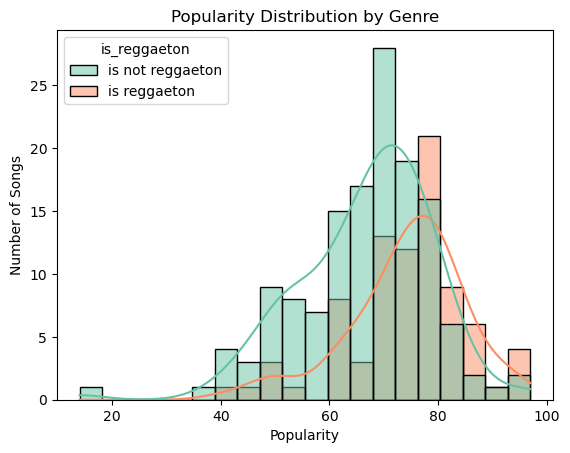

In [116]:
import seaborn as sns

sns.histplot(data=df_tracks, x='popularity', hue='is_reggaeton', bins=20, kde=True, palette='Set2')
plt.title('Popularity Distribution by Genre')
plt.xlabel('Popularity')
plt.ylabel('Number of Songs')
plt.show()

This histogram compares the distribution of song popularity for **reggaeton** and **non-reggaeton** tracks in Bad Bunny's discography. The x-axis represents the Spotify popularity score, and the y-axis indicates the number of songs falling into each popularity bin. A kernel density estimate (KDE) curve is also shown for each genre to illustrate the overall shape of the distribution.

**Interpretation:**

- **Non-reggaeton songs** show a more spread-out distribution, with a peak around the 60–65 popularity range. There are several songs with both lower (0–30s) and higher (80s) popularity values.
- **Reggaeton songs** are more concentrated in the higher popularity range, particularly between 70 and 85, with very few songs in the low-popularity bins.
- The KDE curves confirm this pattern:  
  - The **reggaeton distribution** is skewed toward higher popularity scores.  
  - The **non-reggaeton distribution** is broader and more evenly spread across popularity levels.

This visualization offers a clearer view of how each genre tends to perform in terms of popularity and lays the groundwork for drawing final conclusions about genre influence.


### 📌 Final Conclusions

Based on the statistical analysis and visualizations performed throughout this project, we can confidently state that **Bad Bunny’s reggaeton songs tend to be more popular than his non-reggaeton tracks**. This conclusion is supported by several key findings:

- **Correlation Analysis**:  
  A **moderate positive Pearson correlation (≈ 0.29)** was found between popularity and the reggaeton genre. This suggests a general tendency for reggaeton tracks to receive higher popularity scores, although exceptions exist.

- **Statistical Significance**:  
  An **independent samples t-test** comparing the average popularity of reggaeton and non-reggaeton songs resulted in a **t-statistic of 4.71** and a **p-value of 4.84e-06**. This means the difference in popularity between the two groups is **statistically significant**, not due to random chance.

- **Descriptive Insights**:  
  Despite being fewer in number (**83 vs. 139**), reggaeton songs have a **higher average popularity** (74.16) than non-reggaeton songs (66.78).  
  Histograms show that reggaeton tracks are more concentrated in the upper popularity range, whereas non-reggaeton songs are more evenly distributed.

- **Album-Level Analysis**:  
  - A **moderate positive correlation (~0.44)** exists between the number of reggaeton tracks in an album and its average popularity.  
  - The number of non-reggaeton tracks has **almost no relationship** with album popularity (~0.03 correlation).  
  - The **percentage** of reggaeton tracks shows a **weak** but still positive correlation (~0.13).

Taken together, these results strongly support the initial hypothesis:  
> **Bad Bunny’s reggaeton music consistently performs better in terms of popularity** — both at the individual song level and across entire albums.  

While reggaeton is not the only genre he explores, it clearly plays a major role in driving his commercial success.
